<a href="https://colab.research.google.com/github/Followb1ind1y/D2L_Pytorch_Study_Notes/blob/main/08_D2L_Modern_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dive into Deep Learning 中文学习笔记** 
# **8. 经典卷积神经网络 （Modern Convolutional Neural Networks）**


## **7.6. 卷积神经网络（LeNet）（Convolutional Neural Networks (LeNet)）**

在多层感知机的章节里我们构造了一个含单隐藏层的多层感知机模型来对 `Fashion-MNIST` 数据集中的图像进行分类。每张图像高和宽均是 28 像素。我们将图像中的像素逐行展开，得到长度为 784 的向量，并输入进全连接层中。然而，这种分类方法有一定的**局限性**:

1. 图像在同一列邻近的像素在这个向量中可能相距较远。它们构成的模式可能难以被模型识别。
2. 对于大尺寸的输入图像，使用全连接层容易造成模型过大。假设输入是高和宽均为 1000 像素的彩色照片（含 3 个通道）。即使全连接层输出个数仍是 256，该层权重参数的形状是 $3,000,000×256$：它占用了大约 3 GB的内存或显存。这带来过复杂的模型和过高的存储开销。

卷积层尝试解决这两个问题。一方面，卷积层**保留输入形状**，使图像的像素在高和宽两个方向上的相关性均可能被有效识别；另一方面，卷积层通过**滑动窗口将同一卷积核与不同位置的输入重复计算**，从而避免参数尺寸过大。

卷积神经网络就是含卷积层的网络。本节里我们将介绍一个早期用来识别手写数字图像的卷积神经网络：LeNet。这个名字来源于 LeNet 论文的第一作者 Yann LeCun。LeNet 展示了通过梯度下降训练卷积神经网络可以达到手写数字识别在当时最先进的结果。这个奠基性的工作第一次将卷积神经网络推上舞台，为世人所知。LeNet 的网络结构如下图所示:

<center><img src="https://drive.google.com/uc?export=view&id=1pAmEJD1gkJaQNL5hV-RS9VZa8Xjk4NBe" width=650px /></center>


### **7.6.1. LeNet模型（LeNet）**

LeNet 分为**卷积层块**和**全连接层块**两个部分。下面我们分别介绍这两个模块。

卷积层块里的基本单位是卷积层后接最大池化层：卷积层用来识别图像里的空间模式，如线条和物体局部，之后的最大池化层则用来降低卷积层对位置的敏感性。卷积层块由两个这样的基本单位重复堆叠构成。在卷积层块中，每个卷积层都使用 $5×5$ 的窗口，并在输出上使用 `sigmoid` 激活函数。第一个卷积层输出通道数为 6，第二个卷积层输出通道数则增加到 16。这是因为第二个卷积层比第一个卷积层的输入的高和宽要小，所以增加输出通道使两个卷积层的参数尺寸类似。卷积层块的两个最大池化层的窗口形状均为 $2×2$，且步幅为 2。由于池化窗口与步幅形状相同，池化窗口在输入上每次滑动所覆盖的区域互不重叠。

卷积层块的输出形状为(批量大小, 通道, 高, 宽)。当卷积层块的输出传入全连接层块时，全连接层块会将小批量中每个样本 **变平（*flatten*）**。也就是说，全连接层的输入形状将变成二维，其中第一维是小批量中的样本，第二维是每个样本变平后的向量表示，且向量长度为通道、高和宽的乘积。全连接层块含 3 个全连接层。它们的输出个数分别是120、84和10，其中 10 为输出的类别个数。

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

<center><img src="https://drive.google.com/uc?export=view&id=1VehyarykWB89372fhD2B890mFOJ_G7vQ" width=200px /></center>


In [ ]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


可以看到，在卷积层块中输入的高和宽在逐层减小。卷积层由于使用高和宽均为 5 的卷积核，从而将高和宽分别减小 4，而池化层则将高和宽减半，但通道数则从 1 增加到 16。全连接层则逐层减少输出个数，直到变成图像的类别数 10。

### **7.6.2. 训练（Training）**

下面我们来实验 LeNet 模型。实验中，我们仍然使用 `Fashion-MNIST` 作为训练数据集。

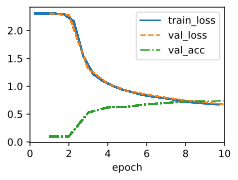

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## **8.1. 深度卷积神经网络（AlexNet）（Deep Convolutional Neural Networks (AlexNet)）**

在 LeNet 提出后的将近 20 年里，神经网络一度被其他机器学习方法超越，如支持向量机。虽然 LeNet 可以在早期的小数据集上取得好的成绩，但是在更大的真实数据集上的表现并不尽如人意。一方面，神经网络计算复杂。虽然 20 世纪 90 年代也有过一些针对神经网络的加速硬件，但并没有像之后 GPU 那样大量普及。因此，训练一个多通道、多层和有大量参数的卷积神经网络在当年很难完成。另一方面，当年研究者还没有大量深入研究参数初始化和非凸优化算法等诸多领域，导致复杂的神经网络的训练通常较困难。

我们在上一节看到，**神经网络可以直接基于图像的原始像素进行分类**。这种称为 **端到端（*end-to-end*）** 的方法节省了很多中间步骤。然而，在很长一段时间里更流行的是研究者通过勤劳与智慧所设计并生成的手工特征。这类图像分类研究的主要流程是：

1. 获取图像数据集；
2. 使用已有的特征提取函数生成图像的特征；
3. 使用机器学习模型对图像的特征分类。

当时认为的机器学习部分仅限最后这一步。如果那时候跟机器学习研究者交谈，他们会认为机器学习既重要又优美。优雅的定理证明了许多分类器的性质。机器学习领域生机勃勃、严谨而且极其有用。然而，如果跟计算机视觉研究者交谈，则是另外一幅景象。他们会告诉你图像识别里“不可告人”的现实是：计算机视觉流程中真正重要的是数据和特征。也就是说，**使用较干净的数据集和较有效的特征甚至比机器学习模型的选择对图像分类结果的影响更大**。

###**8.1.1. 学习特征表示（Representation Learning）**

既然 **特征（*features*）** 如此重要，它该如何 **表示（*Representation*）** 呢？我们已经提到，在相当长的时间里，特征都是 **基于各式各样手工设计的函数从数据中提取的**。事实上，不少研究者通过提出新的特征提取函数不断改进图像分类结果。这一度为计算机视觉的发展做出了重要贡献。

然而，另一些研究者则持异议。他们认为 **特征本身也应该由学习得来**。他们还相信，为了表征足够复杂的输入，特征本身应该分级表示。持这一想法的研究者相信，多层神经网络可能可以学得数据的多级表征，并逐级表示越来越抽象的概念或模式。以图像分类为例，并回忆二维卷积层中物体边缘检测的例子。在多层神经网络中，图像的第一级的表示可以是在特定的位置和⻆度是否出现边缘；而第二级的表示说不定能够将这些边缘组合出有趣的模式，如花纹；在第三级的表示中，也许上一级的花纹能进一步汇合成对应物体特定部位的模式。这样逐级表示下去，最终，模型能够较容易根据最后一级的表示完成分类任务。需要强调的是，输入的逐级表示由多层模型中的参数决定，而这些**参数都是学出来的**。

第一个现代 CNN 以其发明者之一 Alex Krizhevsky 的名字命名为 **AlexNet**，主要**是对 LeNet 的进化改进**。它在 2012 年的 ImageNet 挑战赛中取得了优异的成绩。AlexNet (2012) 及其前身 LeNet (1995) 共享许多架构元素。下图是由 AlexNet 第一层学习到的特征图像：

<center><img src="https://drive.google.com/uc?export=view&id=1BKYPLH6XxfSjm-Fai_KhQbfsXPJ0AV3T" width=450px /></center>


尽管一直有一群执着的研究者不断钻研，试图学习视觉数据的逐级表征，然而很长一段时间里这些野心都未能实现。这其中有诸多因素值得我们一一分析。

**8.1.1.1. 缺失要素一：数据（Missing Ingredient: Data）**

包含许多特征的深度模型**需要大量的有标签的数据**才能表现得比其他经典方法更好。限于早期计算机有限的存储和90年代有限的研究预算，大部分研究只基于小的公开数据集。例如，不少研究论文基于加州大学欧文分校（UCI）提供的若干个公开数据集，其中许多数据集只有几百至几千张图像。这一状况在2010年前后兴起的大数据浪潮中得到改善。特别是，2009年诞生的 ImageNet 数据集包含了 1,000 大类物体，每类有多达数千张不同的图像。这一规模是当时其他公开数据集无法与之相提并论的。 ImageNet 数据集同时推动计算机视觉和机器学习研究进入新的阶段，使此前的传统方法不再有优势。

**8.1.1.2. 缺失要素二：硬件（Missing Ingredient: Hardware）**

深度学习对**计算资源要求很高**。早期的硬件计算能力有限，这使训练较复杂的神经网络变得很困难。然而，通用 GPU 的到来改变了这一格局。很久以来，GPU 都是为图像处理和计算机游戏设计的，尤其是针对大吞吐量的矩阵和向量乘法从而服务于基本的图形变换。值得庆幸的是，这其中的数学表达与深度网络中的卷积层的表达类似。通用 GPU 这个概念在 2001 年开始兴起，涌现出诸如 OpenCL 和 CUDA 之类的编程框架。这使得 **GPU 也在 2010 年前后开始被机器学习社区使用**。

### **8.1.2. AlexNet**

2012年，AlexNet 横空出世。这个模型的名字来源于论文第一作者的姓名 Alex Krizhevsky。AlexNet 使用了 8 层卷积神经网络，并以很大的优势赢得了 ImageNet 2012 图像识别挑战赛。它首次证明了学习到的特征可以超越手工设计的特征，从而一举打破计算机视觉研究的前状。

<center><img src="https://drive.google.com/uc?export=view&id=1V_AHQRvPqeXo0o4ynSqD04E92PacUeN4" width=400px /></center>

AlexNet与LeNet的设计理念非常相似，但也有显著的区别。

**8.1.2.1. 设计框架（Architecture）**

**第一，与相对较小的 LeNet 相比，AlexNet 包含 8 层变换，其中有 5 层卷积和 2 层全连接隐藏层，以及 1 个全连接输出层**。AlexNet 第一层中的卷积窗口形状是 $11×11$。因为 ImageNet 中绝大多数图像的高和宽均比 MNIST 图像的高和宽大 10 倍以上，ImageNet 图像的物体占用更多的像素，所以需要更大的卷积窗口来捕获物体。第二层中的卷积窗口形状减小到 $5×5$，之后全采用 $3×3$。此外，第一、第二和第五个卷积层之后都使用了窗口形状为 $3×3$、步幅为 2 的最大池化层。而且，AlexNet 使用的卷积通道数也大于 LeNet 中的卷积通道数数十倍。

紧接着最后一个卷积层的是两个输出个数为 4096 的全连接层。这两个巨大的全连接层带来将近 1 GB的模型参数。由于早期显存的限制，最早的 AlexNet 使用双数据流的设计使一个 GPU 只需要处理一半模型。幸运的是，显存在过去几年得到了长足的发展，因此通常我们不再需要这样的特别设计了。

**8.1.2.2. 激活函数（Activation Functions）**

**第二，AlexNet 将 sigmoid 激活函数改成了更加简单的 ReLU 激活函数**。一方面，ReLU 激活函数的计算更简单，例如它并没有 sigmoid 激活函数中的求幂运算。另一方面，ReLU 激活函数在不同的参数初始化方法下使模型更容易训练。这是由于当 sigmoid 激活函数输出极接近 0 或 1 时，这些区域的梯度几乎为 0，从而造成反向传播无法继续更新部分模型参数；而 ReLU 激活函数在正区间的梯度恒为 1。因此，若模型参数初始化不当，sigmoid 函数可能在正区间得到几乎为 0 的梯度，从而令模型无法得到有效训练。

**8.1.2.3. 容量控制和预处理（Capacity Control and Preprocessing）**

**第三，AlexNet 通过 丢弃法（*dropout*）控制全连接层的模型复杂度，而 LeNet 只使用权重衰减**。为了进一步增强数据，AlexNet 的训练循环添加了大量图像增强，例如翻转、裁剪和颜色变化。这使得模型更加健壮，更大的样本量有效地减少了过拟合。

下面我们实现稍微简化过的 AlexNet:

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

我们构建了一个单通道数据示例，高和宽均为 224，以观察每一层的输出形状:

In [4]:
AlexNet().layer_summary((1, 1, 224, 224))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

### **8.1.3. 训练（*Training*）**

尽管 AlexNet 在 `ImageNet` 上进行了训练 。我们在这里使用 `Fashion-MNIST`，因为即使在现代 GPU 上训练 ImageNet 模型收敛也可能需要数小时或数天。直接在 `Fashion-MNIST` 上应用 AlexNet 的问题之一是它的图像分辨率较低（$28 \times 28$ 像素）比 `ImageNet` 图像。为了使事情正常进行，我们将它们上采样到 $224 \times 224$. 这通常不是一个明智的做法，因为它只是增加了计算的复杂性而没有增加信息。尽管如此，我们在这里这样做是为了忠实于 `AlexNet` 架构。`resize` 我们使用构造函数中的参数执行此大小调整 `d2l.FashionMNIST`。

现在，我们可以开始训练 AlexNet。与 LeNet 相比，这里的主要变化是使用更小的学习率和更慢的训练，因为网络更深更宽，图像分辨率更高，卷积成本更高。

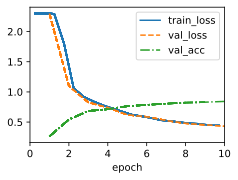

In [5]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

## **8.2. 使用重复元素的网络（VGG）（Networks Using Blocks (VGG)）**

AlexNet 在 LeNet 的基础上增加了 3 个卷积层。但 AlexNet 作者对它们的卷积窗口、输出通道数和构造顺序均做了大量的调整。虽然 AlexNet 指明了深度卷积神经网络可以取得出色的结果，但并没有提供简单的规则以指导后来的研究者如何设计新的网络。

在这节我们将介绍 **VGG Network** (Simonyan and Zisserman, 2014)，它的名字来源于论文作者所在的实验室Visual Geometry Group。VGG 提出了可以通过**重复使用简单的基础块来构建深度模型**的思路。

### **8.2.1. VGG块（VGG Blocks）**

CNN 的基本构件是以下的序列。(i) 带有填充的**卷积层**，以保持分辨率；(ii) **非线性层**，如ReLU；(iii) **池化层**，如最大池化，以降低分辨率。这种方法的问题之一是，**空间分辨率下降得相当快**。Simonyan 和 Zisserman 的关键想法是在下采样过程中以 **块（*block*）** 的形式**在最大池化前使用多个卷积**。他们最初的主要关注点是深层网络还是宽层网络表现更好。例如，连续应用两个 $3×3$ 卷积和单个 $5×5$ 卷积触及相同的像素哪个效果更好。在一个相当详细的分析中，他们表明**深层和窄层网络的表现明显优于浅层的同类网络**。这使深度学习走上了追求更深的网络的道路，在典型的应用中，网络层数超过100层。堆叠 $3×3$  卷积已经成为后期深度网络的一个黄金标准。

VGG 块的组成规律是：**连续使用数个相同的填充为 1、窗口形状为 $3×3$ 的卷积层后接上一个步幅为 2、窗口形状为 $2×2$ 的最大池化层**。卷积层保持输入的高和宽不变，而池化层则对其减半。我们使用 `vgg_block` 函数来实现这个基础的 VGG 块，它可以指定卷积层的数量和输入输出通道数。

对于给定的感受野（与输出有关的输入图片的局部大小），采用堆积的小卷积核优于采用大的卷积核，因为可以**增加网络深度来保证学习更复杂的模式**，而且代价还比较小（参数更少）。例如，在 VGG 中，使用了 3 个 $3×3$ 卷积核来代替 $7×7$ 卷积核，使用了 2 个 $3×3$ 卷积核来代替 $5×5$ 卷积核，这样做的主要目的是在保证具有**相同感知野的条件下**，提升了**网络的深度**，在一定程度上提升了神经网络的效果。


In [ ]:
!pip install d2l==1.0.0b0

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

###**8.2.2. VGG网络（VGG Network）**

与 AlexNet 和 LeNet 一样，VGG 网络由卷积层模块后接全连接层模块构成。卷积层模块串联数个 `vgg_block`，其超参数由变量 `conv_arch` 定义。该变量指定了每个 VGG 块里卷积层个数和输入输出通道数。全连接模块则跟 AlexNet 中的一样。

<center><img src="https://drive.google.com/uc?export=view&id=1lnBwiplHNvqqVI_B7MneqZDPIKpklQ_A" width=400px /></center>


现在我们构造一个 VGG 网络。它有 5 个卷积块，前 2 块使用单卷积层，而后 3 块使用双卷积层。第一块的输入输出通道分别是 1（因为下面要使用的 `Fashion-MNIST` 数据的通道数为 1）和 64，之后每次对输出通道数翻倍，直到变为 512。因为这个网络使用了 8 个卷积层和 3 个全连接层，所以经常被称为 VGG-11。

In [4]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [5]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary((1, 1, 224, 224))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


###**8.2.3. 训练（Training）**

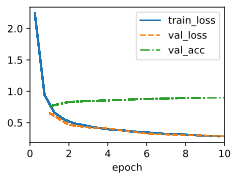

In [6]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## **8.3. 网络中的网络（NiN）（Network in Network (NiN)）**

LeNet、AlexNet 和 VGG 都有一个共同的设计模式：通过一系列卷积层和池化层利用 **空间结构（*spatial structure*）** 提取特征，并通过全连接层对表征进行后处理。AlexNet 和 VGG 对 LeNet 的改进主要在于这些后来的网络如何拓宽和加深这两个模块。这种设计提出了两个主要挑战。首先，架构末端的全连接层会消耗大量参数。例如，即使是像 VGG-11 这样的简单模型也需要一个巨大的 $25088×4096$ 矩阵，在单精度(FP32)情况下几乎要占用 400 MB的 RAM。。这是计算的一个重大障碍。其次，同样不可能在网络中更早地添加全连接层来增加非线性程度：这样做会破坏空间结构并可能需要更多内存。

**网络中的网络（network in network (NiN)）区块** 提供了一个替代方案，能够在一个简单的策略中解决这两个问题。它们是基于一个非常简单的洞察力提出的:（i）使用 $1×1$ 卷积来**增加通道激活的局部非线性**，以及（ii）使用**全局平均池化来整合最后一个表示层**的所有位置。请注意，如果不是因为增加了非线性因素，全局平均汇集将不会有效。

###**8.3.1. NiN块（NiN Blocks）**

我们知道，卷积层的输入和输出通常是四维数组（样本，通道，高，宽），而全连接层的输入和输出则通常是二维数组（样本，特征）。如果想在全连接层后再接上卷积层，则需要将全连接层的输出变换为四维。回忆在之前介绍的 $1×1$ 卷积层。它可以看成全连接层，其中空间维度（高和宽）上的每个元素相当于样本，通道相当于特征。NiN 背后的想法是**在每个像素位置应用一个全连接层**（对于每个高度和宽度）。由此产生的 $1×1$ 卷积可以被认为是一个独立作用于每个像素点的全连接层。因此，NiN 使用 $1×1$ 卷积层来替代全连接层，从而使空间信息能够自然传递到后面的层中去。

下图说明了 VGG 和 NiN 及其块之间的主要结构差异。注意 NiN 块的不同（初始卷积后跟 $1×1$ 卷积，而 VGG 保留 $3×3$ 卷积），最后我们不再需要一个巨大的全连接层。

<center><img src="https://drive.google.com/uc?export=view&id=1z_4wsaWNDfJyQWM6iLNuBtUZtW1-nVcx" width=500px /></center>

NiN 块是 NiN 中的基础块。它由一个卷积层加两个充当全连接层的 $1×1$ 卷积层串联而成。其中第一个卷积层的超参数可以自行设置，而第二和第三个卷积层的超参数一般是固定的。

In [7]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

### **8.3.2. NiN模型 (NiN Model)**

NiN是在AlexNet问世不久后提出的。它们的卷积层设定有类似之处。NiN使用卷积窗口形状分别为 $11×11$、$5×5$ 和 $3×3$ 的卷积层，相应的输出通道数也与 AlexNet 中的一致。每个 NiN 块后接一个步幅为 2、窗口形状为 $3×3$ 的最大池化层。

除使用 NiN 块以外，NiN 还有一个设计与 AlexNet 显著不同：NiN 去掉了 AlexNet 最后的 3 个全连接层，取而代之地，**NiN 使用了输出通道数等于标签类别数的 NiN 块**，然后**使用全局平均池化层对每个通道中所有元素求平均并直接用于分类**。这里的全局平均池化层即窗口形状等于输入空间维形状的平均池化层。NiN 的这个设计的好处是可以**显著减小模型参数尺寸**，从而缓解过拟合。然而，该设计有时会造成获得有效模型的训练时间的增加。

In [8]:
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

In [9]:
NiN().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


###**8.3.3. Training**

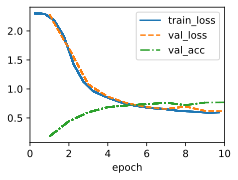

In [10]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## **8.4. 含并行连结的网络（GoogLeNet）（Multi-Branch Networks (GoogLeNet)）**

在 2014 年的 ImageNet 图像识别挑战赛中，一个名叫 GoogLeNet 的网络结构大放异彩。它虽然在名字上向 LeNet 致敬，但在网络结构上已经很难看到 LeNet 的影子。GoogLeNet 吸收了 NiN 中网络串联网络的思想，并在此基础上做了很大改进。GoogLeNet中的关键贡献是网络主体的设计。它以一种巧妙的方式解决了**选择卷积核的问题**。当其他模型还在试图确定使用哪些卷积是最好的时，它简单地连接了多分支的卷积，从而解决了这个问题。

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

###**8.4.1. Inception 块（Inception Blocks）**

GoogLeNet 中的基础卷积块叫作 **Inception 块**，得名于同名电影《盗梦空间》（Inception）。与之前介绍的 NiN 块相比，这个基础块在结构上更加复杂，如下图所示。

<center><img src="https://drive.google.com/uc?export=view&id=1-WyKvR0UbmuNMIAlVtXBFHShHjyfGKo6" width=500px /></center>

由上图可以看出，Inception 块里有 4 条并行的线路。前 3 条线路使用窗口大小分别是 $1×1$、$3×3$ 和 $5×5$ 的卷积层来抽取不同空间尺寸下的信息，其中中间 2 个线路会对输入先做 $1×1$ 卷积来减少输入通道数，以降低模型复杂度。第四条线路则使用 $3×3$ 最大池化层，后接 $1×1$ 卷积层来改变通道数。4 条线路都使用了合适的填充来使输入与输出的高和宽一致。最后我们将每条线路的输出在通道维上连结，并输入接下来的层中去。

Inception 块中可以自定义的超参数是每个层的输出通道数，我们以此来控制模型复杂度。

In [5]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

### **8.4.2. GoogLeNet模型（GoogLeNet Model）**

GoogLeNet 使用总共 9 个模块（*Inception blocks*），分为 3 组，中间使用最大池化层，并在其头部使用全局平均池化来生成其估计。初始块之间的最大池化降低了维度。从本质上讲，第一个模块类似于 AlexNet 和 LeNet。

<center><img src="https://drive.google.com/uc?export=view&id=1UI1HcGUpwS9Kc9-Hw4XnbVGxcPzVHJfU" width=500px /></center>

我们现在可以一块一块地实现 GoogLeNet。第一个模块使用一个 64 通道的 $7 \times 7$ 卷积层。


In [6]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第二模块使用 2 个卷积层：首先是 64 通道的 $1×1$ 卷积层，然后是将通道增大 3 倍的 $3×3$ 卷积层。它对应 Inception 块中的第二条线路。此时我们有 192 个通道。

In [7]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第三模块串联 2 个完整的 Inception 块。第一个 Inception 块的输出通道数为 $64+128+32+32=256$，其中 4 条线路的输出通道数比例为 $64:128:32:32=2:4:1:1$。其中第二、第三条线路先分别将输入通道数减小至 $96/192=1/2$ 和 $16/192=1/12$ 后，再接上第二层卷积层。第二个 Inception 块输出通道数增至 $128+192+96+64=480$，每条线路的输出通道数之比为 $128:192:96:64=4:6:3:2$。其中第二、第三条线路先分别将输入通道数减小至 $128/256=1/2$ 和 $32/256=1/8$。

In [8]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第四模块更加复杂。它串联了 5 个 Inception 块，其输出通道数分别是 $192+208+48+64=512$、$160+224+64+64=512$、$128+256+64+64=512$、$112+288+64+64=528$ 和 $256+320+128+128=832$。这些线路的通道数分配和第三模块中的类似，首先含 $3×3$ 卷积层的第二条线路输出最多通道，其次是仅含 $1×1$ 卷积层的第一条线路，之后是含 $5×5$ 卷积层的第三条线路和含 $3×3$ 最大池化层的第四条线路。其中第二、第三条线路都会先按比例减小通道数。这些比例在各个 Inception 块中都略有不同。

In [9]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

第五模块有输出通道数为 $256+320+128+128=832$ 和 $384+384+128+128=1024$ 的两个 Inception 块。其中每条线路的通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。需要注意的是，第五模块的后面紧跟输出层，该模块同 NiN 一样使用全局平均池化层来将每个通道的高和宽变成 1。最后我们将输出变成二维数组后接上一个输出个数为标签类别数的全连接层。

In [10]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

现在我们 `b1` 通过定义了所有块 `b5`，接下来只需将它们全部组装成一个完整的网络即可:

In [11]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

GoogLeNet模型的计算复杂，而且不如VGG那样便于修改通道数。请注意，在所选择的通道数量、降维前的块数、通道间容量的相对划分等方面，有大量相对任意的超参数。这在很大程度上是由于在引入GoogLeNet的时候，还没有网络定义或设计探索的自动工具。

目前，我们将进行的唯一修改是将输入的高度和宽度从224减少到96，以便在 Fashion-MNIST 上有一个合理的训练时间。这就简化了计算过程。让我们来看看各个模块之间输出形状的变化。

In [12]:
model = GoogleNet().layer_summary((1, 1, 96, 96))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


### **8.4.3. Training**

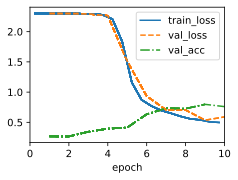

In [13]:
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

Inception 块相当于一个有4条线路的子网络。它通过不同窗口形状的卷积层和最大池化层来并行抽取信息，并使用 $1×1$ 卷积层减少通道数从而降低模型复杂度。

GoogLeNet 将多个设计精细的 Inception 块和其他层串联起来。其中 Inception 块的通道数分配之比是在 ImageNet 数据集上通过大量的实验得来的。

GoogLeNet 和它的后继者们一度是 ImageNet 上最高效的模型之一：在类似的测试精度下，它们的计算复杂度往往更低。

## **8.5. 批量归一化（Batch Normalization）**

本节我们介绍 **批量归一化（*batch normalization*）层**，它能让较深的神经网络的训练变得更加容易。在预测房价的例子里，我们对输入数据做了标准化处理：处理后的任意一个特征在数据集中所有样本上的均值为 0、标准差为 1。标准化处理输入数据使各个特征的分布相近：这往往更容易训练出有效的模型。

通常来说，数据标准化预处理对于浅层模型就足够有效了。随着模型训练的进行，当每层中参数更新时，靠近输出层的输出较难出现剧烈变化。但对深层神经网络来说，**即使输入数据已做标准化，训练中模型参数的更新依然很容易造成靠近输出层输出的剧烈变化**。这种计算数值的不稳定性通常令我们难以训练出有效的深度模型。

批量归一化的提出正是为了应对深度模型训练的挑战。在模型训练时，批量归一化利用小批量上的均值和标准差，不断调整神经网络中间输出，从而使整个神经网络在各层的**中间输出的数值更稳定**。

### **8.5.2. Batch Normalization Layers**

全连接层和卷积层的批量归一化实现方式略有不同。批量归一化与其他层的一个关键区别是，由于批量归一化一次对一个完整的迷你批进行操作，我们不能像以前引入其他层时那样直接忽略批量维度。

**8.5.2.1. 对全连接层做批量归一化（Fully Connected Layers）**

我们先考虑如何对全连接层做批量归一化。通常，我们将批量归一化层置于全连接层中的仿射变换和激活函数之间。设全连接层的输入为$\boldsymbol{u}$，权重参数和偏差参数分别为 $\boldsymbol{W}$ 和 $\boldsymbol{b}$，激活函数为$\phi$。设批量归一化的运算符为$\text{BN}$。那么，使用批量归一化的全连接层的输出为

$$\phi(\text{BN}(\boldsymbol{x})),$$

其中批量归一化输入$\boldsymbol{x}$由仿射变换

$$\boldsymbol{x} = \boldsymbol{W\boldsymbol{u} + \boldsymbol{b}}$$

得到。考虑一个由$m$个样本组成的小批量，仿射变换的输出为一个新的小批量$\mathcal{B} = \{\boldsymbol{x}^{(1)}, \ldots, \boldsymbol{x}^{(m)} \}$。它们正是批量归一化层的输入。对于小批量$\mathcal{B}$中任意样本$\boldsymbol{x}^{(i)} \in \mathbb{R}^d, 1 \leq  i \leq m$，批量归一化层的输出同样是$d$维向量

$$\boldsymbol{y}^{(i)} = \text{BN}(\boldsymbol{x}^{(i)}),$$

并由以下几步求得。首先，对小批量$\mathcal{B}$求均值和方差：

$$\boldsymbol{\mu}_\mathcal{B} \leftarrow \frac{1}{m}\sum_{i = 1}^{m} \boldsymbol{x}^{(i)},$$
$$\boldsymbol{\sigma}_\mathcal{B}^2 \leftarrow \frac{1}{m} \sum_{i=1}^{m}(\boldsymbol{x}^{(i)} - \boldsymbol{\mu}_\mathcal{B})^2,$$

其中的平方计算是按元素求平方。接下来，使用按元素开方和按元素除法对$\boldsymbol{x}^{(i)}$标准化：

$$\hat{\boldsymbol{x}}^{(i)} \leftarrow \frac{\boldsymbol{x}^{(i)} - \boldsymbol{\mu}_\mathcal{B}}{\sqrt{\boldsymbol{\sigma}_\mathcal{B}^2 + \epsilon}},$$

这里$\epsilon > 0$是一个很小的常数，保证分母大于0。在上面标准化的基础上，批量归一化层引入了两个可以学习的模型参数，拉伸（scale）参数 $\boldsymbol{\gamma}$ 和偏移（shift）参数 $\boldsymbol{\beta}$。这两个参数和$\boldsymbol{x}^{(i)}$形状相同，皆为$d$维向量。它们与$\boldsymbol{x}^{(i)}$分别做按元素乘法（符号$\odot$）和加法计算：

$${\boldsymbol{y}}^{(i)} \leftarrow \boldsymbol{\gamma} \odot \hat{\boldsymbol{x}}^{(i)} + \boldsymbol{\beta}.$$

至此，我们得到了$\boldsymbol{x}^{(i)}$的批量归一化的输出$\boldsymbol{y}^{(i)}$。
值得注意的是，可学习的拉伸和偏移参数保留了不对$\hat{\boldsymbol{x}}^{(i)}$做批量归一化的可能：此时只需学出$\boldsymbol{\gamma} = \sqrt{\boldsymbol{\sigma}_\mathcal{B}^2 + \epsilon}$和$\boldsymbol{\beta} = \boldsymbol{\mu}_\mathcal{B}$。我们可以对此这样理解：如果批量归一化无益，理论上，学出的模型可以不使用批量归一化。

**8.5.2.2. 对卷积层做批量归一化（Convolutional Layers）**

对卷积层来说，批量归一化发生在**卷积计算之后、应用激活函数之前**。如果卷积计算输出多个通道，我们需要对这些通道的输出分别做批量归一化，且**每个通道都拥有独立的拉伸和偏移参数，并均为标量**。设小批量中有$m$个样本。在单个通道上，假设卷积计算输出的高和宽分别为$p$和$q$。我们需要对该通道中$m \times p \times q$个元素同时做批量归一化。对这些元素做标准化计算时，我们使用相同的均值和方差，即该通道中$m \times p \times q$个元素的均值和方差。

**8.5.2.4. 预测时的批量归一化（Batch Normalization During Prediction）**

使用批量归一化训练时，我们可以将批量大小设得大一点，从而使批量内样本的均值和方差的计算都较为准确。将训练好的模型用于预测时，我们希望模型对于任意输入都有确定的输出。因此，单个样本的输出不应取决于批量归一化所需要的随机小批量中的均值和方差。一种常用的方法是通过移动**平均估算整个训练数据集的样本均值和方差**，并在预测时使用它们得到确定的输出。可见，和丢弃层一样，批量归一化层在训练模式和预测模式下的计算结果也是不一样的。

### **8.5.3. 从零开始实现（Implementation from Scratch）**

In [14]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

接下来，我们自定义一个 `BatchNorm` 层。它保存参与求梯度和迭代的拉伸参数 `gamma` 和偏移参数 `beta`，同时也维护移动平均得到的均值和方差，以便能够在模型预测时被使用。`BatchNorm` 实例所需指定的 `num_features` 参数对于全连接层来说应为输出个数，对于卷积层来说则为输出通道数。

In [15]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

### **8.5.4. 使用批量归一化层的LeNet（LeNet with Batch Normalization）**

In [16]:
class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            BatchNorm(120, num_dims=2), nn.Sigmoid(), nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

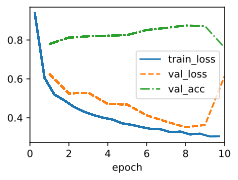

In [17]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

### **8.5.5. 简洁实现（Concise Implementation）**

In [18]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))

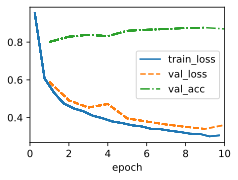

In [19]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## **8.6. 残差网络（ResNet）（Residual Networks (ResNet) and ResNeXt）**

让我们先思考一个问题：对神经网络模型添加新的层，充分训练后的模型是否只可能更有效地降低训练误差？理论上，原模型解的空间只是新模型解的空间的子空间。也就是说，如果我们能将新添加的层训练成恒等映射 $f(x)=x$，新模型和原模型将同样有效。由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。**然而在实践中，添加过多的层后训练误差往往不降反升**。即使利用批量归一化带来的数值稳定性使训练深层模型更加容易，该问题仍然存在。针对这一问题，何恺明等人提出了**残差网络（ResNet**）。它在 2015 年的 ImageNet 图像识别挑战赛夺魁，并深刻影响了后来的深度神经网络的设计。

### **8.6.2. 残差块（Residual Blocks）**

让我们聚焦于神经网络局部。如下图所示，设输入为 $x$。假设我们希望学出的理想映射为 $f(x)$，从而作为图中上方激活函数的输入。左图虚线框中的部分需要直接拟合出该映射 $f(x)$，而右图虚线框中的部分则需要拟合出有关恒等映射的残差映射 $f(x)−x$。残差映射在实际中往往更容易优化。以本节开头提到的恒等映射作为我们希望学出的理想映射 $f(x)$。我们只需将图中右图虚线框内上方的加权运算（如仿射）的权重和偏差参数学成 0，那么 $f(x)$ 即为恒等映射。实际中，当理想映射 $f(x)$ 极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动。图中右图也是 ResNet 的基础块，即**残差块（*residual block*）**。其中实线承载层输入 $x$ 加法运算符称为**残差连接（*residual connection*）**。在残差块中，输入可通过跨层的数据线路更快地向前传播。事实上，残差块可以被认为是多分支 Inception 块的一个特例：它有两个分支，其中一个是恒等映射。

<center><img src="https://drive.google.com/uc?export=view&id=1qnQNRWlTmgiXuuks_SrNi7fTDusJgnTH" width=400px /></center>

ResNet 沿用了 VGG 全 $3×3$ 卷积层的设计。残差块里首先有 2 个有相同输出通道数的 $3×3$ 卷积层。每个卷积层后接一个批量归一化层和 ReLU 激活函数。然后我们将输入跳过这两个卷积运算后直接加在最后的 ReLU 激活函数前。这样的设计要求两个卷积层的输出与输入形状一样，从而可以相加。如果想改变通道数，就需要引入一个额外的 $1×1$ 卷积层来将输入变换成需要的形状后再做相加运算。

残差块的实现如下。它可以设定输出通道数、是否使用额外的 $1×1$ 卷积层来修改通道数以及卷积层的步幅。


In [ ]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)